In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq
from langchain_openai import AzureChatOpenAI

groq_api_key = os.getenv('GROQ_API_KEY')
os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')

# llm = ChatGroq(groq_api_key=groq_api_key, model_name="gemma2-9b-it")

llm = AzureChatOpenAI(
    api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
)


llm.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': F

In [3]:
from langchain_community.tools import DuckDuckGoSearchRun

def web_search(query: str):
    """Searches DuckDuckGo using Langchain's DuckDuckgoSearchRun tool"""
    search = DuckDuckGoSearchRun()
    return search.invoke(query)

# result = search_duckduckgo("what are AI agents")
# print(result)

def add(a: float, b: float) -> float:
    """Add two numbers"""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

In [4]:
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

math_agent = create_react_agent(model=llm, 
                                tools=[add, multiply],
                                name="math_expert",
                                prompt="You are a math expert. Always use one tool at a time."
                                )

research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    name="reserch_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

In [5]:
workflow = create_supervisor(
    [research_agent, math_agent],
    model=llm,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
    )
)

In [6]:
app = workflow.compile()

result = app.invoke({"messages": [("user", "what is quantum computing?")]})
result

{'messages': [HumanMessage(content='what is quantum computing?', additional_kwargs={}, response_metadata={}, id='367a9617-9631-484c-b39d-612552c24489'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fZcGxJjtijKdQiDfjF7SSTZS', 'function': {'arguments': '{}', 'name': 'transfer_to_reserch_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 94, 'total_tokens': 109, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_f

In [7]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

what is quantum computing?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_reserch_expert (call_fZcGxJjtijKdQiDfjF7SSTZS)
 Call ID: call_fZcGxJjtijKdQiDfjF7SSTZS
  Args:
================================= Tool Message =================================
Name: transfer_to_reserch_expert

Successfully transferred to reserch_expert
================================== Ai Message ==================================
Name: reserch_expert

Quantum computing is an area of computing focused on developing computer technology based on the principles of quantum theory. Quantum theory explains the behavior of energy and material on the atomic and subatomic levels. Traditional computers use bits as the smallest unit of data, represented as 0s or 1s. Quantum computers, on the other hand, use quantum bits or qubits.

Qubits take advantage of quantum ph

In [8]:
app = workflow.compile()

result = app.invoke({"messages": [("user", "what is the weather in delhi today. Multiply it by 2 and add 5")]})

for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the weather in delhi today. Multiply it by 2 and add 5
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_reserch_expert (call_mutGyYRKc3fdAUTJP213imXC)
 Call ID: call_mutGyYRKc3fdAUTJP213imXC
  Args:
================================= Tool Message =================================
Name: transfer_to_reserch_expert

Successfully transferred to reserch_expert
================================== Ai Message ==================================
Name: reserch_expert

The weather in Delhi today is 16°C. 

You requested to "multiply it by 2 and add 5." As a researcher, I do not perform mathematical calculations. Please proceed with the calculation as needed.
================================== Ai Message ==================================
Name: reserch_expert

Transferring back to supervisor
Tool Calls:
  transfer_back_to_supervisor (1e08

### Supervisor Agent with low level agent

In [21]:
from typing import Literal

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode

@tool 
def get_weather(location: str):
    """Call to get the current weather"""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy"
    else:
        return "It's 32 degrees Celsius and sunny."
    
tools = [get_weather]

llm_with_tool = llm.bind_tools(tools)

# ---Existing agent workflow definition ---
def call_model(state: MessagesState):
    """Call the LLM with the conversation so far."""
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", END]:
    """If there is a tool call requested, to to 'tools', else end."""
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools" 
    return END 

weather_workflow = StateGraph(MessagesState)

tool_node = ToolNode(tools)

weather_workflow.add_node("agent", call_model)
weather_workflow.add_node("tools", tool_node)

weather_workflow.add_edge(START, "agent")
weather_workflow.add_conditional_edges("agent", should_continue)
weather_workflow.add_edge("tools", "agent")

weather_agent_graph = weather_workflow.compile(name="weather_agent")

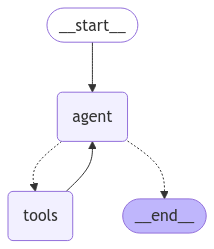

In [22]:
from IPython.display import display, Image

display(Image(weather_agent_graph.get_graph().draw_mermaid_png()))

In [23]:
from langgraph_supervisor import create_supervisor

supervisor_workflow = create_supervisor(
    agents = [weather_agent_graph],
    model=llm_with_tool,
    prompt = (
        "You are a supervisor managing a weather agent. "
        "For any weather-related question, call the 'weather_agent' to handle it."
    ),
    output_mode="last_message",
    # output_mode="full_history",
    supervisor_name="supervisor_agent",
)

supervisor_app = supervisor_workflow.compile()

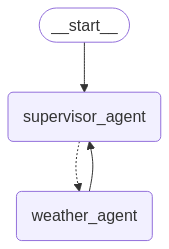

In [24]:
from IPython.display import display, Image

display(Image(supervisor_app.get_graph().draw_mermaid_png()))

In [25]:
supervisor_app.invoke({"messages": [HumanMessage(content="hello, how are you?")]})

{'messages': [HumanMessage(content='hello, how are you?', additional_kwargs={}, response_metadata={}, id='614f9e23-228b-4a01-957e-35b151d16b7c'),
  AIMessage(content="Hello! I'm doing well, thank you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filter

In [27]:
supervisor_app.invoke({"messages": [HumanMessage(content="how is weather in munich")]})

{'messages': [HumanMessage(content='how is weather in munich', additional_kwargs={}, response_metadata={}, id='e74b2968-cf67-4ead-a7a4-8e4eeae8a1f8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JoYlaq3h9xM9FQDknIeUu8p3', 'function': {'arguments': '{}', 'name': 'transfer_to_weather_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 70, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, '